In [1]:
from llama_pq import LlamaForCausalLM
import torch

pretrained = 'meta-llama/Meta-Llama-3-8B-Instruct'
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
model = LlamaForCausalLM.from_pretrained(
    pretrained,
    torch_dtype=torch.bfloat16,
    device_map=str(device),
    _attn_implementation = "eager"
)
model.eval()
print(model)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Li

In [2]:
collection = torch.load('activation.pt')

def get_qkv(info, model, layer):
    h = 32
    group = 4
    q_proj = model.model.layers[layer].self_attn.q_proj.weight.T
    k_proj = model.model.layers[layer].self_attn.k_proj.weight.T
    v_proj = model.model.layers[layer].self_attn.v_proj.weight.T
    x = info[0].squeeze(0)
    seqlen = info[1]
    # print(q_proj.shape, k_proj.shape, v_proj.shape, x.shape, seqlen)
    data = x[:seqlen, :]
    query = x[seqlen:, :]
    q = torch.matmul(query, q_proj).view(query.shape[0], h, -1)
    k = torch.matmul(data, k_proj).view(data.shape[0], h//group, -1).repeat_interleave(dim=1, repeats=group)
    v = torch.matmul(data, v_proj).view(data.shape[0], h//group, -1).repeat_interleave(dim=1, repeats=group)
    # print(q.shape, k.shape, v.shape)
    return q.transpose(1, 0), k.transpose(1, 0), v.transpose(1, 0)

tensor([[  0, 295, 848,  ..., 714, 711, 710],
        [  0, 445, 241,  ..., 714, 762, 834],
        [  0, 241, 854,  ..., 759, 762, 834],
        ...,
        [  0,  71, 346,  ..., 655, 691, 654],
        [  0, 430, 230,  ..., 710, 654, 691],
        [  0, 104, 231,  ..., 671, 677, 711]], device='cuda:0')
efSearch 16 bounded queue True 	   0.001 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 16 bounded queue False 	   0.001 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 32 bounded queue True 	   0.001 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 32 bounded queue False 	   0.001 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 64 bounded queue True 	   0.002 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 64 bounded queue False 	   0.001 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 128 bounded queue True 	   0.003 ms per query, R@1 0.9706, missing rate 0.0000
efSearch 128 bounded queue False 	   0.002 ms per query, R@1 0.9706, missing rat

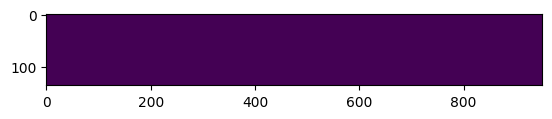

In [23]:
import faiss
import time
import matplotlib.pyplot as plt

def evaluate(index, xq, gt, k):
    nq, d = xq.shape
    t0 = time.time()
    D, I = index.search(xq, k)
    t1 = time.time()
    # print(D, I)

    missing_rate = (I == -1).sum() / float(k * nq)
    recall_at_1 = (I == gt[:, :1]).sum() / float(nq)
    print("\t %7.3f ms per query, R@1 %.4f, missing rate %.4f" % (
        (t1 - t0) * 1000.0 / nq, recall_at_1, missing_rate))

def compute_gt(query, data, k):
    mip = torch.matmul(query, data.T)
    _, indices = torch.topk(mip, k=data.shape[0], dim=-1)
    gt = torch.zeros_like(mip)
    gt = gt.scatter(-1, indices, 1)
    plt.imshow(gt.float().cpu().detach().numpy())
    print(indices)
    return indices.cpu().detach().numpy()

def anns(query, data, vector, k):
    gt = compute_gt(query, data, k)
    
    query = query.float().cpu().detach().numpy()
    data = data.float().cpu().detach().numpy()
    index = faiss.IndexHNSWFlat(data.shape[-1], 32)
    index.hnsw.efConstruction = 40
    index.verbose = True
    index.add(data)
    for efSearch in 16, 32, 64, 128, 256:
        for bounded_queue in [True, False]:
            print("efSearch", efSearch, "bounded queue", bounded_queue, end=' ')
            index.hnsw.search_bounded_queue = bounded_queue
            index.hnsw.efSearch = efSearch
            evaluate(index, query, gt, k)
    return 0, 0, 0
    # return recall, count

example = 3
layer = 10
head = 3
topk = 10
input_info = collection['1'][str(layer)]
q, k, v = get_qkv(input_info, model, layer)
recall, ratio, error = anns(q[head], k[head], v[head], topk)